In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

# 1. Data set

In [2]:
# Load data
data = tfds.load('Malaria', as_supervised=True, shuffle_files=False)
# as the data only consists of train split, manual spliting will be needed later
data = data['train']

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteQ4XNMY/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


tf.Tensor(1, shape=(), dtype=int64)
(103, 103, 3)
tf.Tensor(1, shape=(), dtype=int64)
(106, 121, 3)
tf.Tensor(0, shape=(), dtype=int64)
(139, 142, 3)
tf.Tensor(1, shape=(), dtype=int64)
(130, 118, 3)
tf.Tensor(1, shape=(), dtype=int64)
(121, 109, 3)


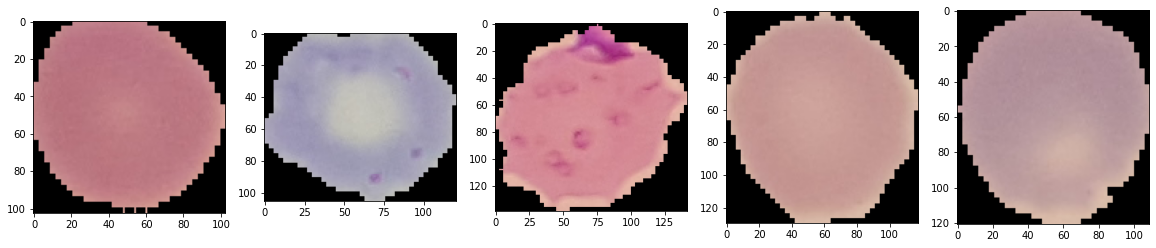

In [3]:
# visualize few data points
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i,(input,label) in enumerate(data.take(5)):
    print(label)
    print(input.shape)
    axes[i].imshow(input)

tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)


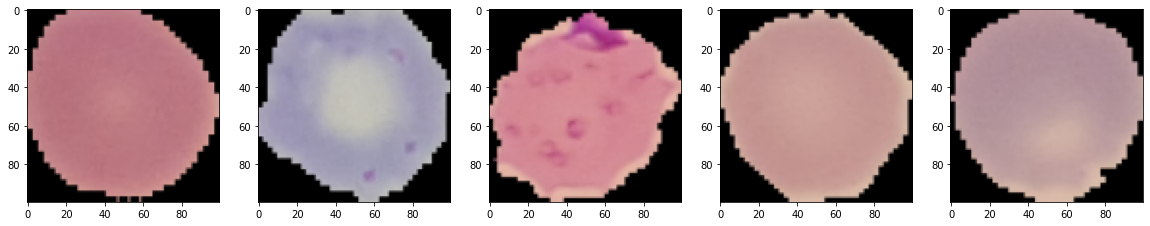

In [4]:
# Resize image by distorting the ratio and onehot encode label
def preprocess_data(input,label):
    resized_image = tf.image.resize(images=input,
                                    size=[100,100],  # downsample
                                    antialias=True)
    return resized_image, tf.one_hot(label, depth=2)

resized_data = data.map(preprocess_data)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i,(input,label) in enumerate(resized_data.take(5)):
    print(label)
    print(input.shape)
    axes[i].imshow(tf.cast(input, tf.int32))  # imshow requires dtype=int

tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([1. 0.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)
tf.Tensor([0. 1.], shape=(2,), dtype=float32)
(100, 100, 3)


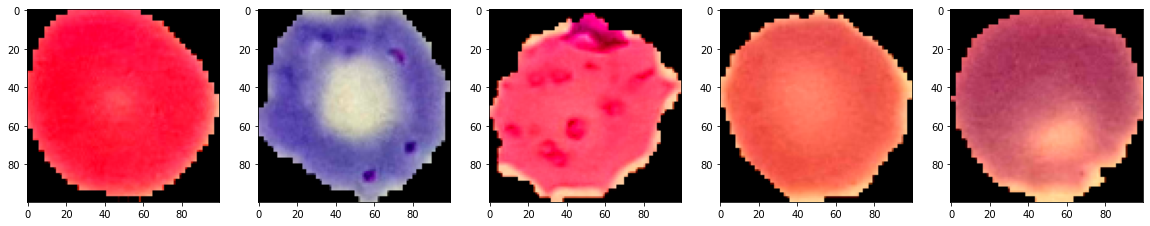

In [5]:
# Standardise each image
normalized_data = resized_data.map(lambda image,label: (tf.image.per_image_standardization(image),label))

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,5))
for i,(input,label) in enumerate(normalized_data.take(5)):
    print(label)
    print(input.shape)
    axes[i].imshow(input)

In [6]:
# Prepare data by batching/shuffling/prefetching
BATCH_SIZE = 64
BUFFER_SIZE = 27558  # match the total num. data points
PREFETCH_FACTOR = tf.data.experimental.AUTOTUNE

normalized_data = normalized_data.shuffle(BUFFER_SIZE)  # for each trial different splits
train_data = normalized_data.take(int(BUFFER_SIZE*0.8)).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(PREFETCH_FACTOR)
test_data = normalized_data.skip(int(BUFFER_SIZE*0.8)).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).prefetch(PREFETCH_FACTOR)

# 2. Model

In [7]:
INPUT_SHAPE = input.shape  # 'input' is one random standardised image used in viz

# Prespecify layers to be used
# define input_shape
input_layer = tf.keras.layers.Conv2D(filters=20, 
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='valid',
                                    activation='relu',
                                    input_shape=INPUT_SHAPE)
# equiv. to input_layer except no def. of input_shape
conv_layer = tf.keras.layers.Conv2D(filters=20, 
                                    kernel_size=(3,3),
                                    strides=(1,1),
                                    padding='valid',
                                    activation='relu')
# pool for generalisations
pool_layer = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                          strides=None)

# Building the model
cnn = tf.keras.models.Sequential()
cnn.add(input_layer)
cnn.add(pool_layer)
for _ in range(3):  # just use same layers multiple times
    cnn.add(conv_layer)
    cnn.add(pool_layer)  
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(2, activation='softmax'))  # readout layer

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 20)        560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  3620      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 642       
Total params: 4,822
Trainable params: 4,822
Non-trainable params: 0
_________________________________________________________________


# 3. Training

In [17]:
tf.keras.backend.clear_session()

# Hyperparameter
EPOCHS = 20
LEARNING_RATE = 1e-4

# Configure loss func/optimiser/accuracy metric
cnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
            optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            metrics=tf.keras.metrics.binary_accuracy)

# custom callback to get train/test metrics for each batch
class CustomCallback(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs=None):
    self.loss = []
    self.acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.loss.append(logs.get('loss'))
    self.acc.append(logs.get('binary_accuracy'))

  def on_test_begin(self, logs=None):
    self.loss = []
    self.acc = []

  def on_test_batch_end(self, batch, logs=None):
    self.loss.append(logs.get('loss'))
    self.acc.append(logs.get('binary_accuracy'))    

total_history = {'test_loss':[], 'test_acc':[], 'train_loss':[], 'train_acc':[]}
for epoch in range(EPOCHS):
  # loss and acc for each batch
  for train_batch, test_batch in zip(train_data,test_data):
    # train
    train_history = CustomCallback()
    cnn.fit(x=train_batch[0],
            y=train_batch[1],
            batch_size=64,
            epochs=1,
            callbacks=[train_history],
            verbose=0)
    # test
    test_history = CustomCallback()
    cnn.evaluate(x=test_batch[0],
                y=test_batch[1],
                batch_size=64,
                return_dict=True,
                callbacks=[test_history],
                 verbose=0)
    
    total_history['train_loss'].append(train_history.loss)
    total_history['train_acc'].append(train_history.acc)
    total_history['test_loss'].append(test_history.loss)
    total_history['test_acc'].append(test_history.acc)

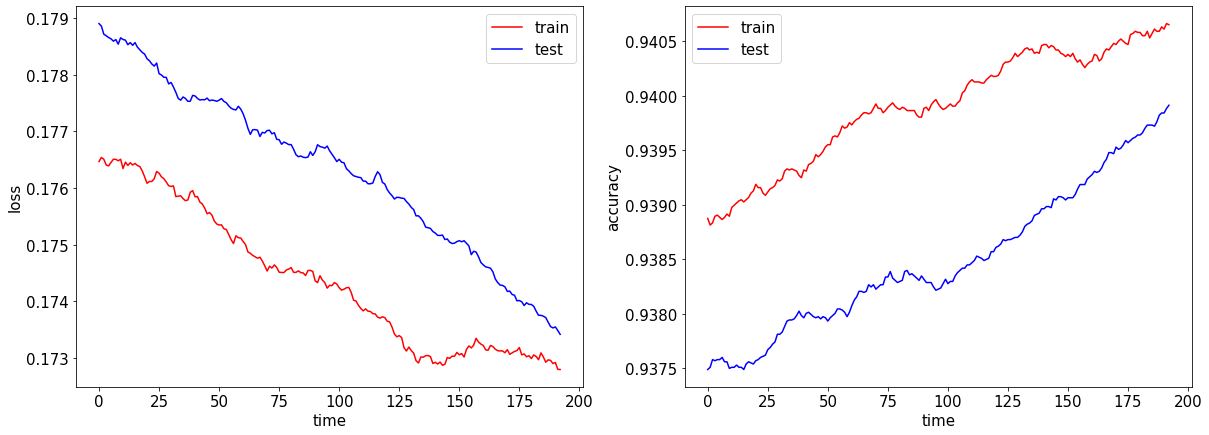

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
matplotlib.rcParams.update({'font.size': 15})

# convolve for computing moving average 
N = int(1721 * 0.9)
# loss
axes[0].plot(np.convolve(np.array(total_history['train_loss']).flatten(),
                         np.ones(N)/N, mode='valid'),
             color='r', label='train'
             )
axes[0].plot(np.convolve(np.array(total_history['test_loss']).flatten(),
                         np.ones(N)/N, mode='valid'),
             color='b', label='test')
axes[0].legend()
axes[0].set(xlabel='time', ylabel='loss')

# accuracy
axes[1].plot(np.convolve(np.array(total_history['train_acc']).flatten(),
                         np.ones(N)/N, mode='valid'),
             color='r', label='train')
axes[1].plot(np.convolve(np.array(total_history['test_acc']).flatten(),
                         np.ones(N)/N, mode='valid'),
             color='b', label='test')
axes[1].legend()
axes[1].set(xlabel='time', ylabel='accuracy')

plt.show()